In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from windrose import WindroseAxes

 ## Reading benin-malanville csv from data folder and putting it in df variable in memory

In [3]:
df = pd.read_csv("../data/benin-malanville.csv")

In [4]:
# df.describe() helps you understand the distribution, spread, and central tendency of your data at a glance.
df.describe()

GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0.000000      24.200000      28.800000       1.000000   
50%         4.300000      28.000000      55.100000       1.900000   
75%       447.900000      32.300000      80.100000       3.100000   
max      1342.300000      43.800000     100.000000      19.500000   

              WSgust        WSstdev             WD        WDstdev  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean        2.809195       0.473390     153.435172       8.582407   
std         2.029120       0.273395     102.332842       6.385864   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.300000       0.400000      59.000000       3.700000   
50%         2.600000       0.500000     181.000000       8.600000   
75%         4.100000       0.600000     235.100000      12.300000   
max        26.600000       4.200000     360.000000      99.400000   

                  BP       Cleaning  Precipitation          TModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      994.197199       0.000923       0.001905      35.246026   
std         2.474993       0.030363       0.037115      14.807258   
min       985.000000       0.000000       0.000000       9.000000   
25%       993.000000       0.000000       0.000000      24.200000   
50%       994.000000       0.000000       0.000000      30.000000   
75%       996.000000       0.000000       0.000000      46.900000   
max      1003.000000       1.000000       2.500000      81.000000   

               TModB  Comments  
count  525600.000000       0.0  
mean       32.471736       NaN  
std        12.348743       NaN  
min         8.100000       NaN  
25%        23.600000       NaN  
50%        28.900000       NaN  
75%        41.500000       NaN  
max        72.500000       NaN

In [5]:
#getting sum of all null values for each columns
missing = df.isna().sum().sort_values(ascending=False)
missing

Comments         525600
GHI                   0
Timestamp             0
DNI                   0
DHI                   0
ModB                  0
ModA                  0
RH                    0
WS                    0
WSgust                0
Tamb                  0
WSstdev               0
WD                    0
BP                    0
WDstdev               0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
dtype: int64

In [6]:
# calculating Missing percentage for each columns
missing_pct = (missing / len(df) * 100).round(2)
missing_pct

Comments         100.0
GHI                0.0
Timestamp          0.0
DNI                0.0
DHI                0.0
ModB               0.0
ModA               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
Tamb               0.0
WSstdev            0.0
WD                 0.0
BP                 0.0
WDstdev            0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
dtype: float64

In [7]:
# list columns >5% null
cols_over5 = missing_pct[missing_pct > 5].index.tolist()
print("Columns >5% missing:", cols_over5)

Columns >5% missing: ['Comments']


In [8]:
#removing Comments from the df. since it all value is null, no useful information for our analysis
df = df.drop(columns=['Comments'])


In [9]:
#Comments column not exist any more on the df
print(df.columns)

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB'],
      dtype='object')


### Outlier Detection & Basic Cleaning

# 🧠 Reason for selecting those specific columns

We selected:
**["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]**

because these are the main continuous measurement variables in the dataset — the ones where outliers are **most likely to indicate sensor errors or extreme weather conditions**, rather than just normal variation.

---

## 🔍 1. Why these columns matter for data quality checks

These are all continuous sensor measurements.

Because they record physical quantities (solar radiation, wind speed, etc.), you can easily detect problems by:
1. Looking for **impossible or missing values** (like negative irradiance or 0 during midday).
2. Checking for **extreme spikes (outliers)** that break physical limits.
3. Comparing relationships (e.g., **DHI should not exceed GHI**).


In [10]:
target_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
print(target_cols)

['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']


In [11]:
df[target_cols].describe()

GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB             WS         WSgust  
count  525600.000000  525600.000000  525600.000000  
mean      228.883576       2.121113       2.809195  
std       316.536515       1.603466       2.029120  
min         0.000000       0.000000       0.000000  
25%         0.000000       1.000000       1.300000  
50%         4.300000       1.900000       2.600000  
75%       447.900000       3.100000       4.100000  
max      1342.300000      19.500000      26.600000

##  Check and clean missing values, outliers, incorrect entries

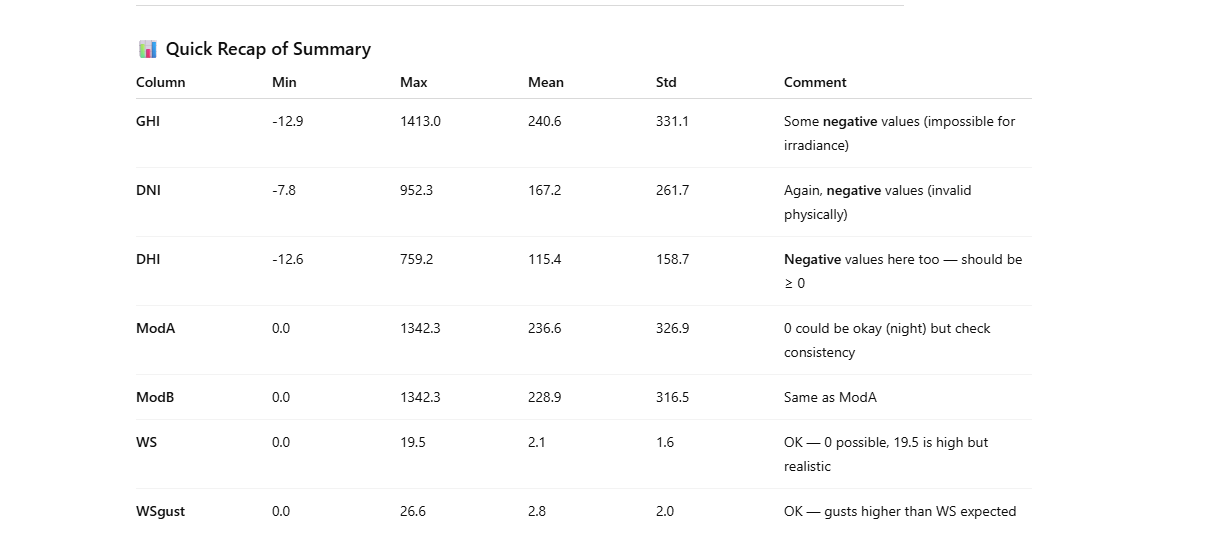

In [12]:
# Remove rows with negative values in GHI, DNI, or DHI
df = df[(df["GHI"] >= 0) & (df["DNI"] >= 0) & (df["DHI"] >= 0)]


In [13]:
df[target_cols].describe()

GHI            DNI            DHI           ModA  \
count  246878.000000  246878.000000  246878.000000  246878.000000   
mean      513.411100     356.480524     247.397346     501.775502   
std       304.765569     279.731019     143.420836     307.789277   
min         0.000000       0.000000       0.000000       0.000000   
25%       239.000000      61.200000     141.200000     218.800000   
50%       520.300000     352.250000     227.800000     502.100000   
75%       790.000000     605.300000     336.200000     786.400000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB             WS         WSgust  
count  246878.000000  246878.000000  246878.000000  
mean      485.418619       2.802063       3.722219  
std       298.429501       1.540762       1.898862  
min         0.000000       0.000000       0.000000  
25%       211.800000       1.700000       2.400000  
50%       484.900000       2.700000       3.600000  
75%       757.700000       3.800000       4.900000  
max      1342.300000      16.000000      22.300000

In [14]:
# since we don't have missing values for our target cols,  we do nothing to clean missing values
missing_counts = df[target_cols].isna().sum()
print(missing_counts)

GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


#### outliers

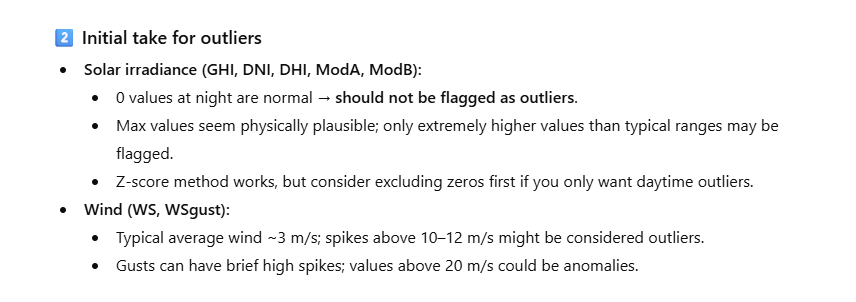

## Boxplots show points outside the whiskers, usually considered outliers.

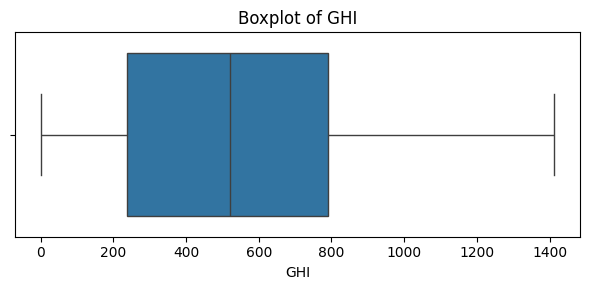

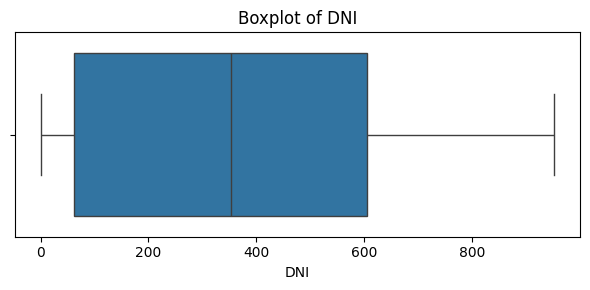

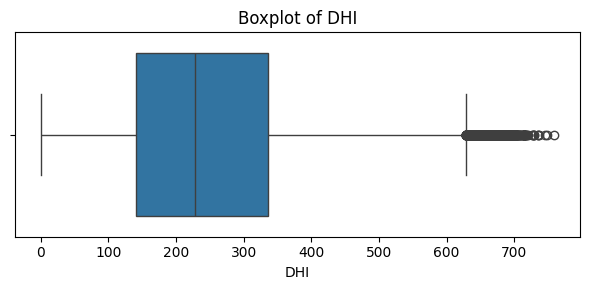

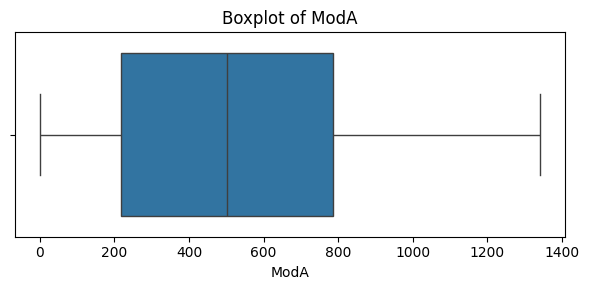

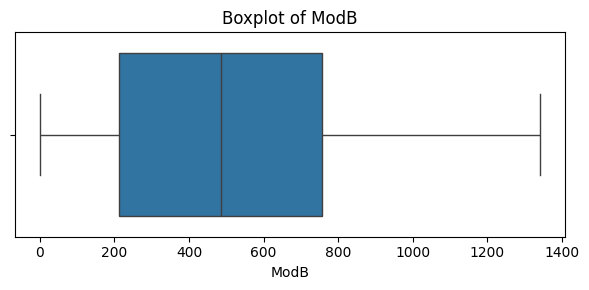

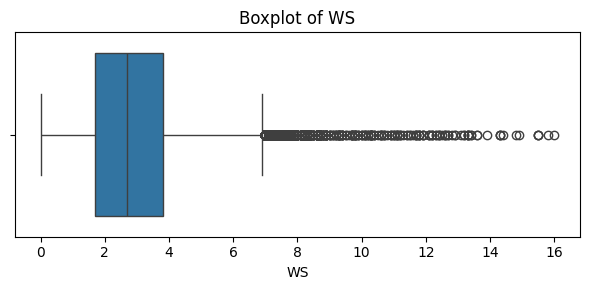

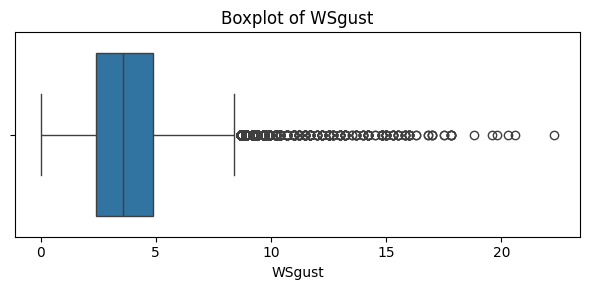

In [15]:
for col in target_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

In [16]:
#remove outliers
# Compute z-scores for selected columns
z = np.abs(zscore(df[target_cols], nan_policy="omit"))

# Define a threshold (standard: 3 standard deviations)
threshold = 3
# 4️Keep only rows where all z-scores are below the threshold
df_no_outliers = df[(z < threshold).all(axis=1)]

# --- Remove physical outliers for wind ---
df_no_outliers = df_no_outliers[df_no_outliers["WSgust"] < 20]
df_no_outliers = df_no_outliers[df_no_outliers["WS"] < 15]

# --- Remove extreme statistical outliers for DHI ---
Q1 = df_no_outliers["DHI"].quantile(0.25)
Q3 = df_no_outliers["DHI"].quantile(0.75)
IQR = Q3 - Q1

# Keep rows within the IQR range (allow slightly lenient upper bound)
df_no_outliers = df_no_outliers[(df_no_outliers["DHI"] >= Q1 - 1.5 * IQR) & (df_no_outliers["DHI"] <= Q3 + 3 * IQR)]

# Optional: see how many rows were removed
removed_count = len(df) - len(df_no_outliers)
print(f"Removed {removed_count:,} outlier rows out of {len(df):,} total daytime rows.")

Removed 959 outlier rows out of 246,878 total daytime rows.


In [17]:
# Export cleaned DataFrame to data/<country>_clean.csve
df_no_outliers.to_csv("../data/benin-malanville_clean.csv", index=False)

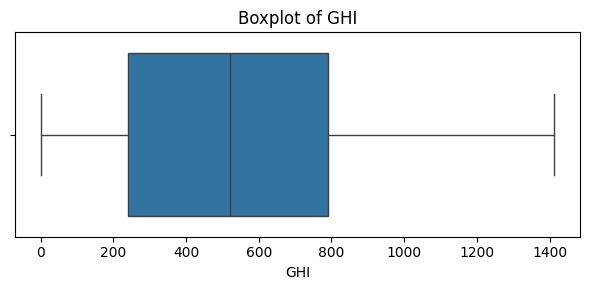

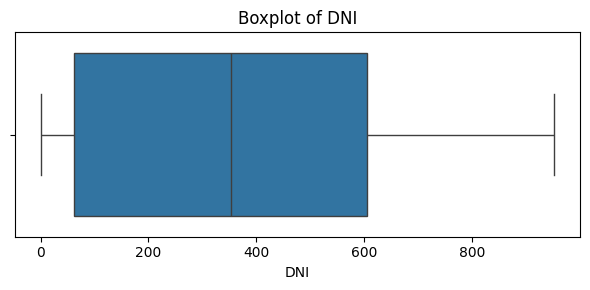

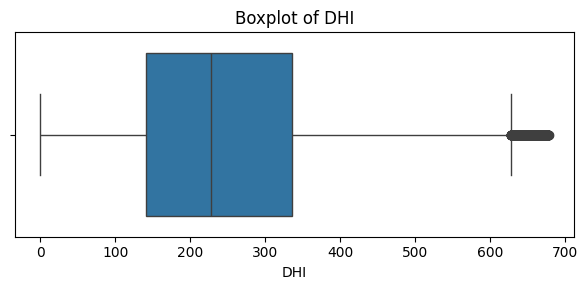

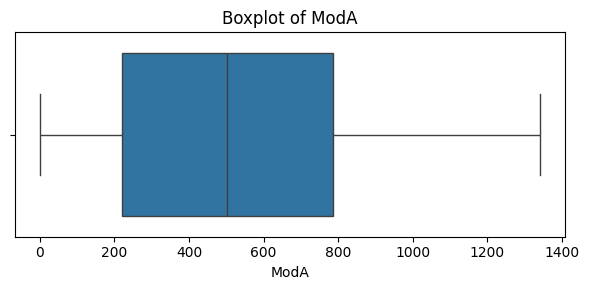

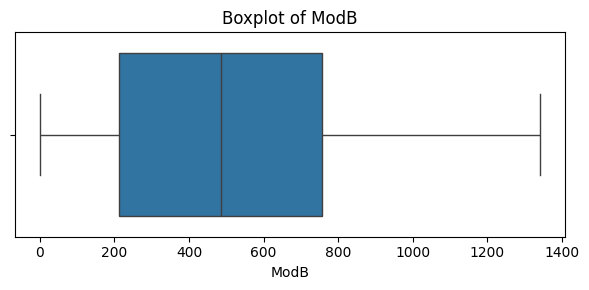

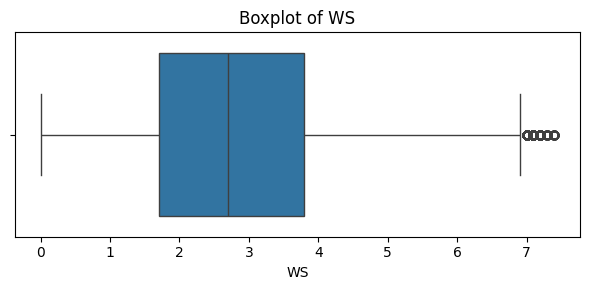

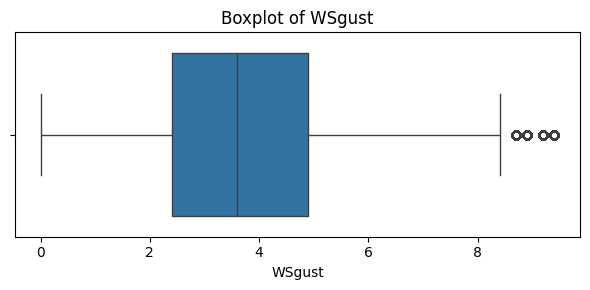

In [18]:
for col in target_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_no_outliers[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

## Time Series Analysis

<Figure size 1600x800 with 0 Axes>

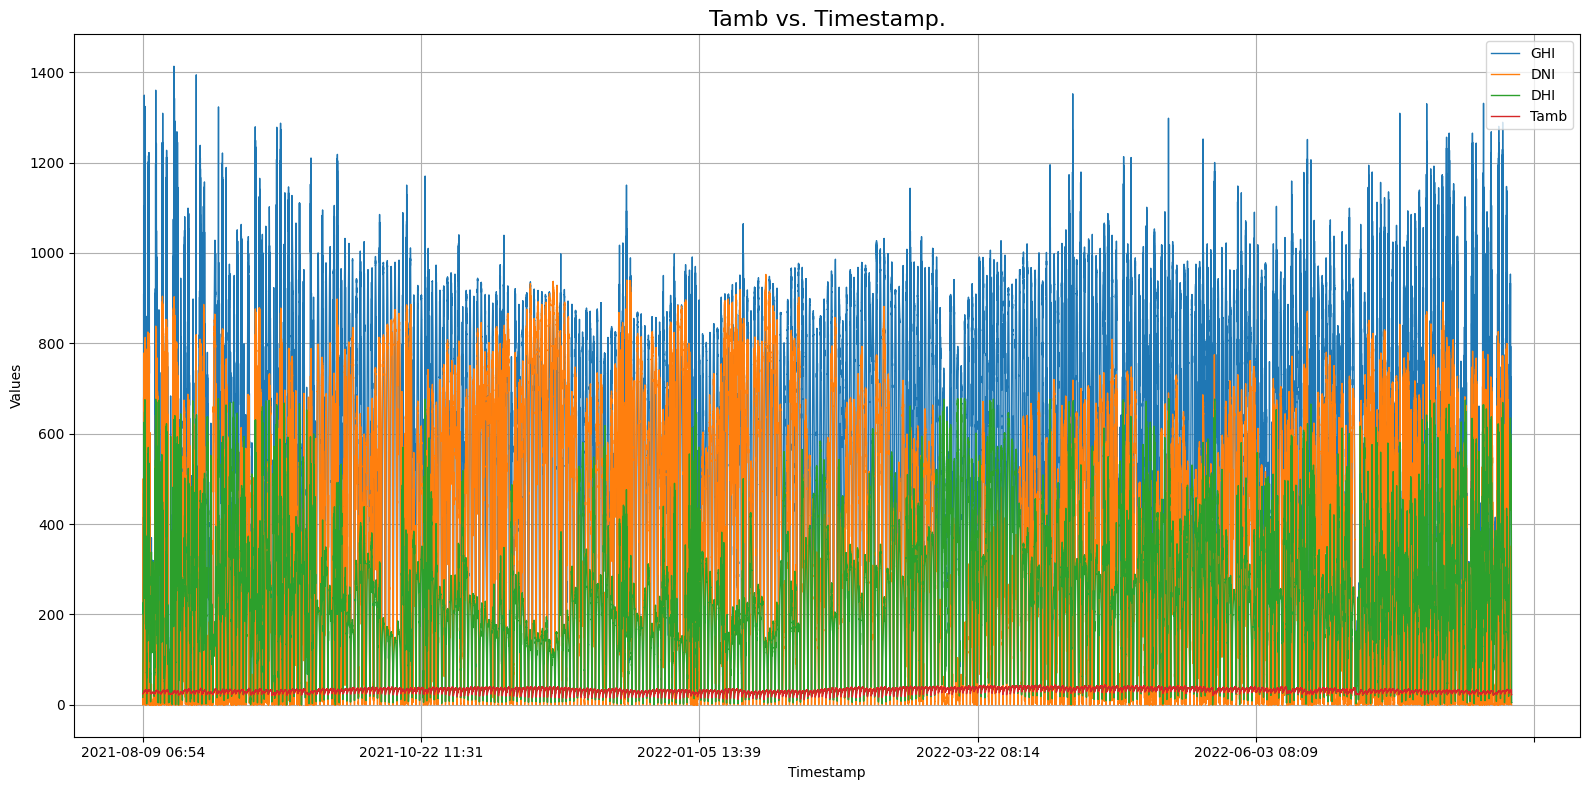

In [19]:
# Set as index (makes time series plotting easier)
df_clean_with_timestap_index = df_no_outliers.copy()
df_clean_with_timestap_index.set_index('Timestamp', inplace=True)
# Create a multi-line plot
plt.figure(figsize=(16, 8))

# Plot each variable
df_clean_with_timestap_index[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(16, 8), linewidth=1)

plt.title("Tamb vs. Timestamp.", fontsize=16)
plt.ylabel("Values")
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show();

In [20]:
# Convert index (strings) -> DatetimeIndex (coerce errors to NaT)
df_clean_with_timestap_index.index = pd.to_datetime(df_clean_with_timestap_index.index, errors='coerce')


##### Monthly patterns

C:\Users\hp\AppData\Local\Temp\ipykernel_23252\628903696.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_clean_with_timestap_index.resample('M')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()


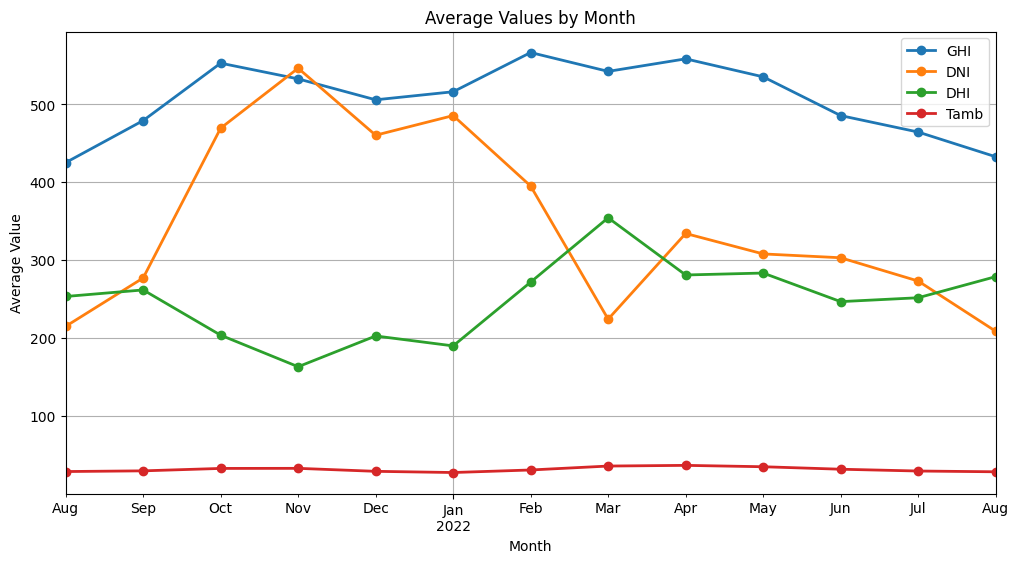

In [21]:
monthly_avg = df_clean_with_timestap_index.resample('M')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_avg.plot(figsize=(12,6), marker='o', linewidth=2)
plt.title("Average Values by Month")
plt.ylabel("Average Value")
plt.xlabel("Month")
plt.grid(True)
plt.show()

##### Daily patterns (hourly trends)

C:\Users\hp\AppData\Local\Temp\ipykernel_23252\3786722520.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg = df_clean_with_timestap_index.resample('H')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()


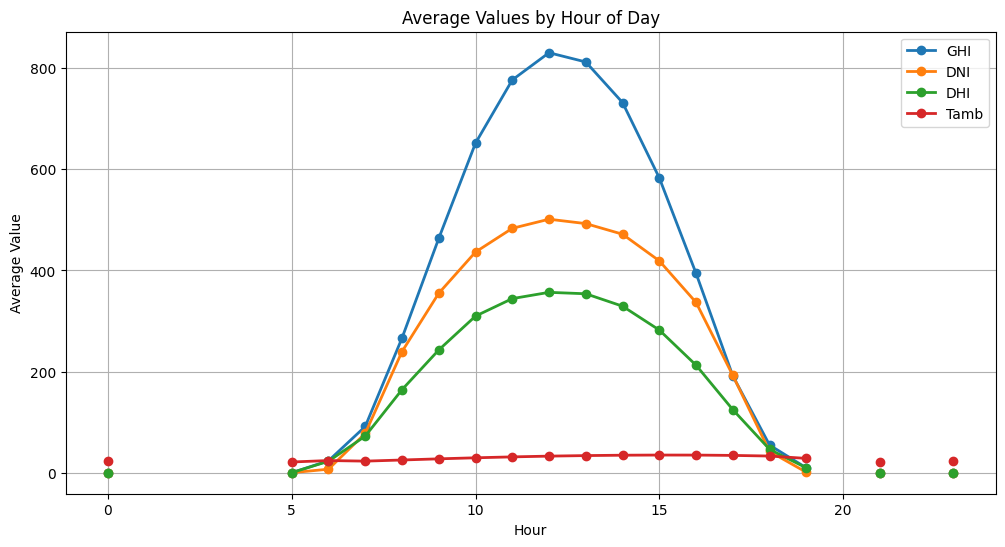

In [22]:
hourly_avg = df_clean_with_timestap_index.resample('H')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_avg.groupby(hourly_avg.index.hour).mean().plot(figsize=(12,6), marker='o', linewidth=2)
plt.title("Average Values by Hour of Day")
plt.ylabel("Average Value")
plt.xlabel("Hour")
plt.grid(True)
plt.show()

##### anomalies, such as peaks in solar irradiance or temperature fluctuations.
“Anomalies, such as peaks in solar irradiance or temperature fluctuations” — Explained
When we talk about anomalies in your dataset, we mean data points that behave very differently from the normal pattern.
They can be caused by natural variations, sensor errors, shading events, or atmospheric changes.
Example:
On a clear day, GHI is usually around 900 W/m² at noon.
If one reading suddenly shows 1500 W/m², that’s an anomalous peak.

Detected 833 anomalies (extreme peaks or drops).


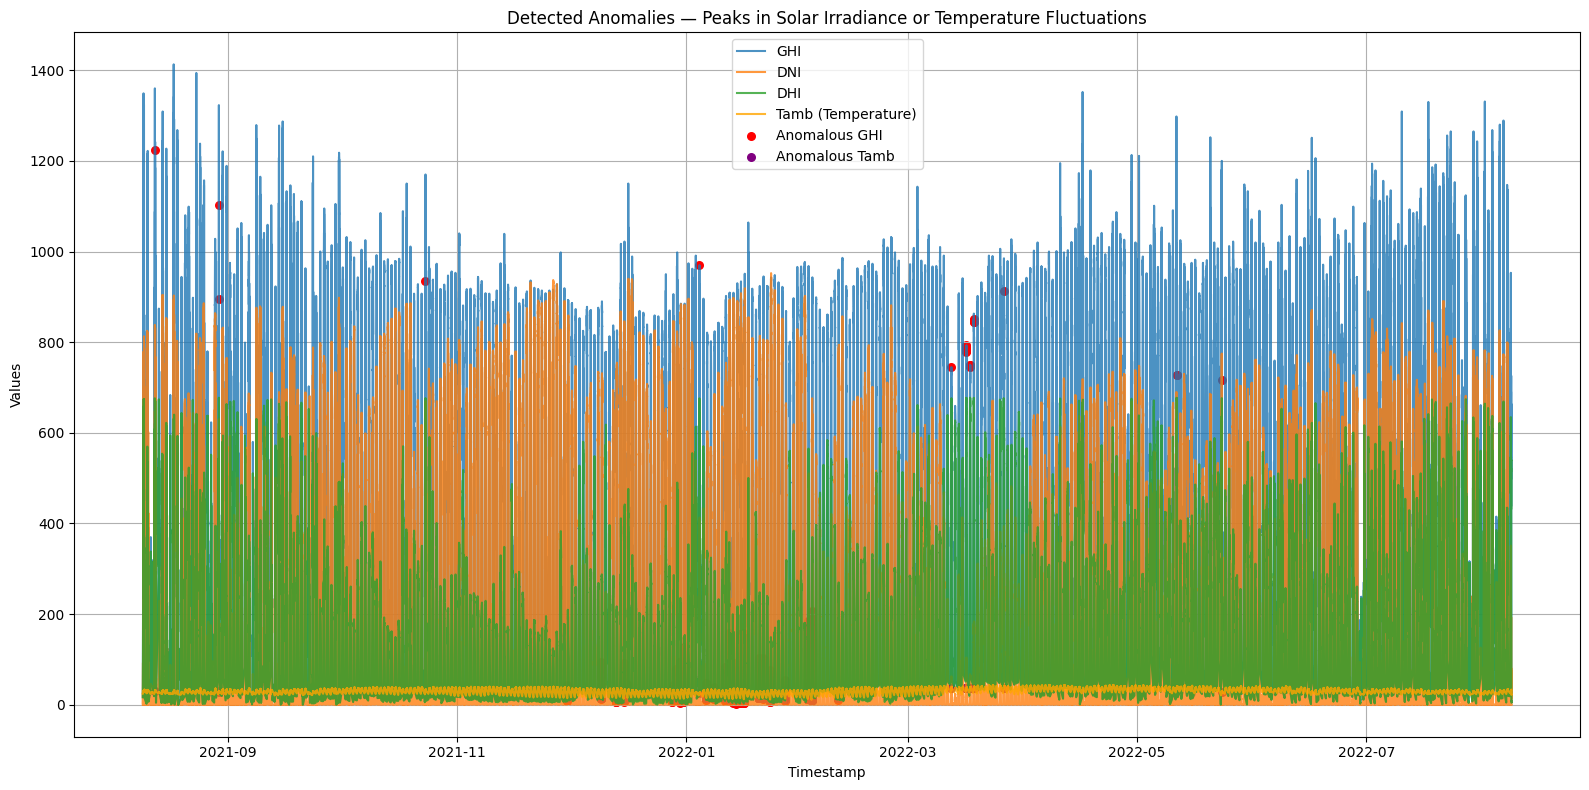

In [23]:

# --- Detect anomalies in solar irradiance and temperature ---
# Compute z-scores for each variable to detect peaks or unusual drops
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    df_clean_with_timestap_index[f'{col}_zscore'] = zscore(df_clean_with_timestap_index[col].dropna())
    
# Define anomalies where |z| > 3 (extreme deviations)
anomalies = df_clean_with_timestap_index[(df_clean_with_timestap_index['GHI_zscore'].abs() > 3) |
               (df_clean_with_timestap_index['DNI_zscore'].abs() > 3) |
               (df_clean_with_timestap_index['DHI_zscore'].abs() > 3) |
               (df_clean_with_timestap_index['Tamb_zscore'].abs() > 3)]

print(f"Detected {len(anomalies)} anomalies (extreme peaks or drops).")

# --- Plot anomalies for visual inspection ---
plt.figure(figsize=(16,8))
plt.plot(df_clean_with_timestap_index.index, df_clean_with_timestap_index['GHI'], label='GHI', alpha=0.8)
plt.plot(df_clean_with_timestap_index.index, df_clean_with_timestap_index['DNI'], label='DNI', alpha=0.8)
plt.plot(df_clean_with_timestap_index.index, df_clean_with_timestap_index['DHI'], label='DHI', alpha=0.8)
plt.plot(df_clean_with_timestap_index.index, df_clean_with_timestap_index['Tamb'], label='Tamb (Temperature)', alpha=0.8, color='orange')

# Highlight detected anomalies
plt.scatter(anomalies.index, anomalies['GHI'], color='red', label='Anomalous GHI', s=30)
plt.scatter(anomalies.index, anomalies['Tamb'], color='purple', label='Anomalous Tamb', s=30)

plt.title("Detected Anomalies — Peaks in Solar Irradiance or Temperature Fluctuations")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cleaning Impact

In [26]:
df2 = pd.read_csv("../data/benin-malanville.csv")

**df2** → your pre-clean data.

**df_clean_with_timestap_index** → your post-clean data
I’ll update all code and the explanation accordingly.
This version will clearly show how ModA and ModB improved after cleaning by grouping on the "Cleaning flag". 

**Compare ModA & ModB Before vs After Cleaning**

In [27]:
##Step 1 — Label datasets. Mark each dataset with its cleaning stage:
df2['Stage'] = 'Pre-Clean'
df_clean_with_timestap_index['Stage'] = 'Post-Clean'

In [28]:
# Step 2 — Combine the two datasets Combine them into one DataFrame for comparison:
combined_df = pd.concat([df2, df_clean_with_timestap_index], axis=0)

In [41]:
df.head()

Timestamp   GHI  DNI   DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
413  2021-08-09 06:54  16.7  0.0  16.5  16.1  16.3  24.2  98.8  0.0     0.0   
414  2021-08-09 06:55  18.2  0.1  18.0  17.4  17.6  24.2  98.8  0.0     0.0   
415  2021-08-09 06:56  19.7  0.3  19.5  18.7  18.9  24.2  98.8  0.0     0.0   
416  2021-08-09 06:57  21.1  0.6  20.9  19.9  20.1  24.2  98.9  0.0     0.0   
417  2021-08-09 06:58  22.5  1.1  22.2  21.1  21.3  24.2  98.9  0.0     0.0   

     ...   BP  Cleaning  Precipitation  TModA  TModB  GHI_zscore  DNI_zscore  \
413  ...  997         0            0.0   24.2   23.7   -1.629817   -1.274372   
414  ...  997         0            0.0   24.3   23.8   -1.624895   -1.274014   
415  ...  997         0            0.0   24.3   23.9   -1.619973   -1.273299   
416  ...  997         0            0.0   24.4   23.9   -1.615380   -1.272227   
417  ...  997         0            0.0   24.5   24.0   -1.610786   -1.270439   

     DHI_zscore  Tamb_zscore      Stage  
413   -1.609932    -1.295277  Pre-Clean  
414   -1.599473    -1.295277  Pre-Clean  
415   -1.589015    -1.295277  Pre-Clean  
416   -1.579253    -1.295277  Pre-Clean  
417   -1.570189    -1.295277  Pre-Clean  

[5 rows x 23 columns]

In [29]:
# Step 3 — Group by Cleaning flag and Stage Compute the average ModA and ModB values for each cleaning flag and stage:
avg_mods = (
    combined_df
    .groupby(['Cleaning', 'Stage'])[['ModA', 'ModB']]
    .mean()
    .reset_index()
)

print(avg_mods.head())

   Cleaning       Stage        ModA        ModB
0         0  Post-Clean  502.127388  485.801199
1         0   Pre-Clean  236.524253  228.816071
2         1  Post-Clean  308.255694  302.947826
3         1   Pre-Clean  307.229278  301.972165


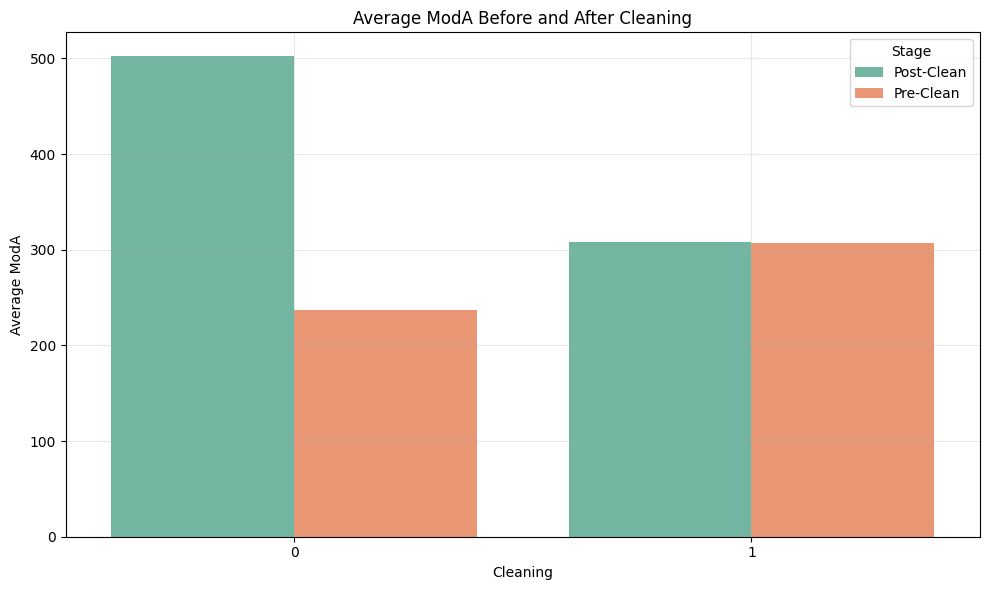

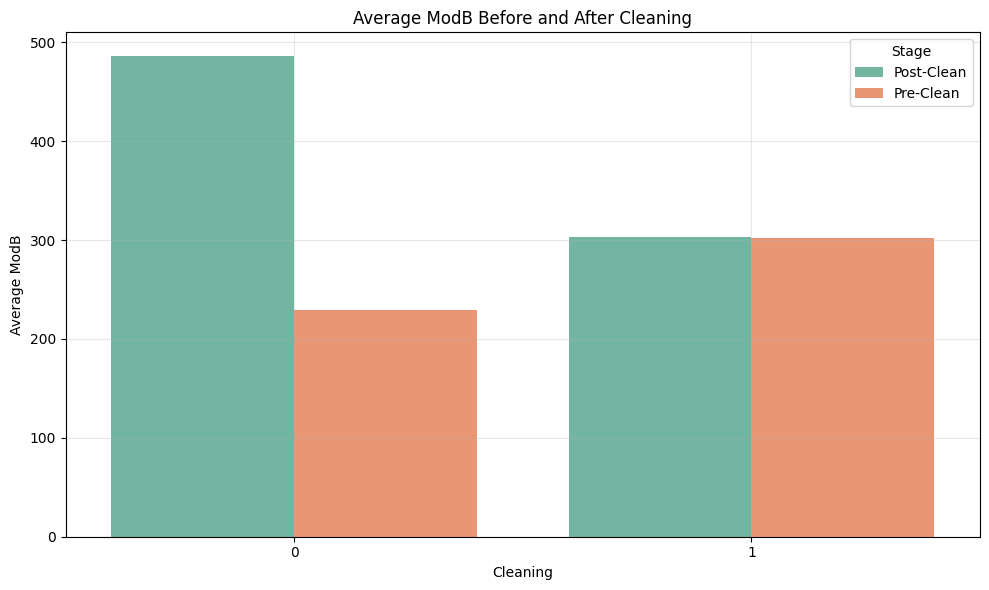

In [30]:
# Step 4 — Plot the comparison (side-by-side bars) Plot average ModA and ModB values for pre-clean vs post-clean:
# Plot ModA
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_mods,
    x='Cleaning', y='ModA', hue='Stage',
    palette='Set2'
)
plt.title("Average ModA Before and After Cleaning")
plt.xlabel("Cleaning")
plt.ylabel("Average ModA")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot ModB
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_mods,
    x='Cleaning', y='ModB', hue='Stage',
    palette='Set2'
)
plt.title("Average ModB Before and After Cleaning")
plt.xlabel("Cleaning")
plt.ylabel("Average ModB")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Correlation & Relationship Analysis


#####  Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).
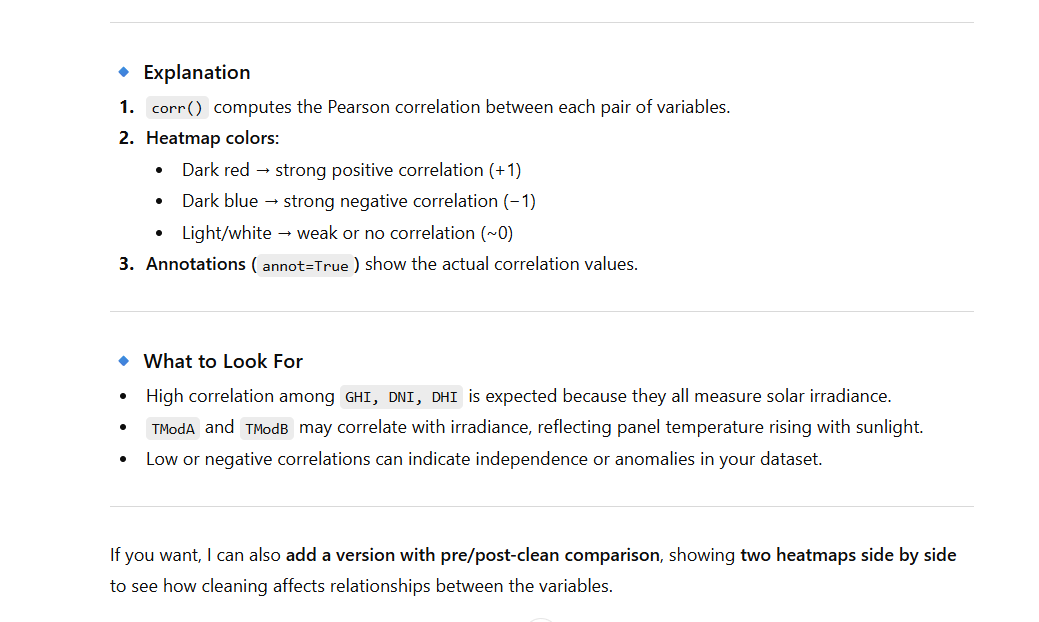

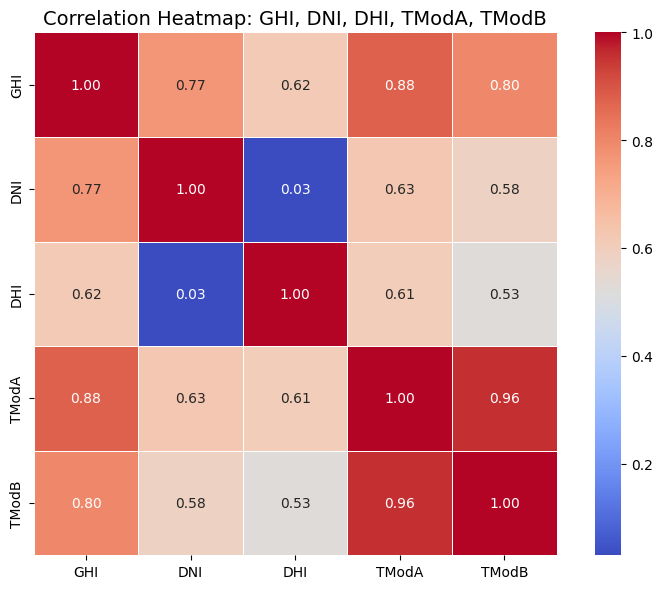

In [45]:
# Select only the relevant columns
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']

# Compute the correlation matrix
corr_matrix = df_clean_with_timestap_index[cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Heatmap: GHI, DNI, DHI, TModA, TModB", fontsize=14)
plt.tight_layout()
plt.show()

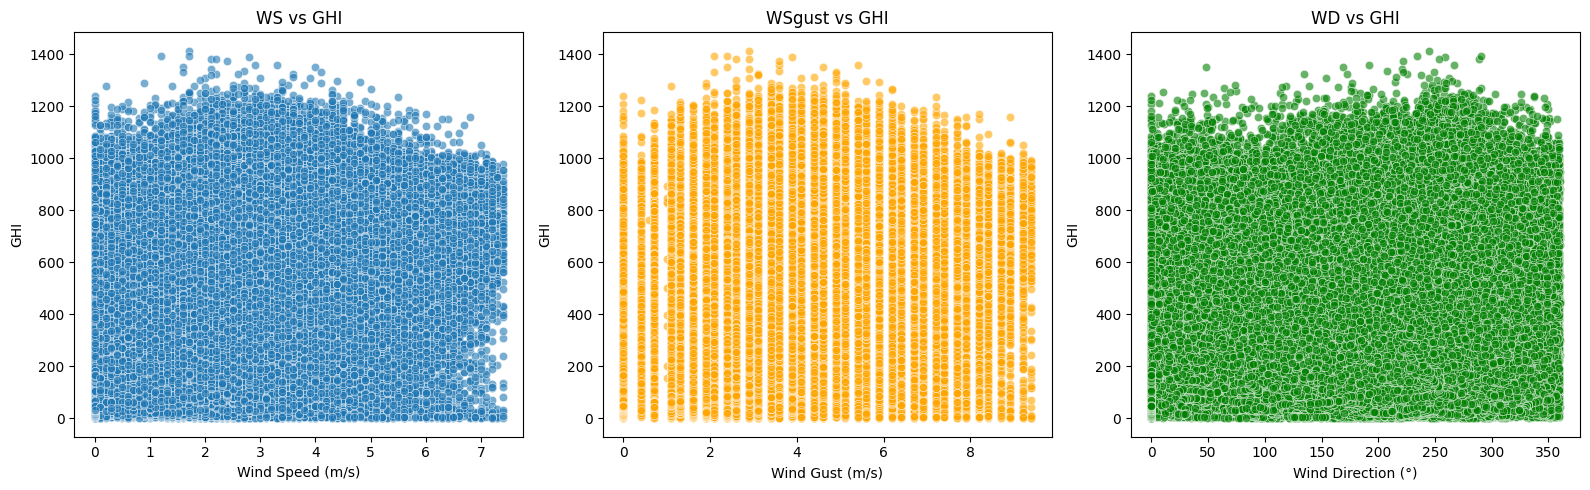

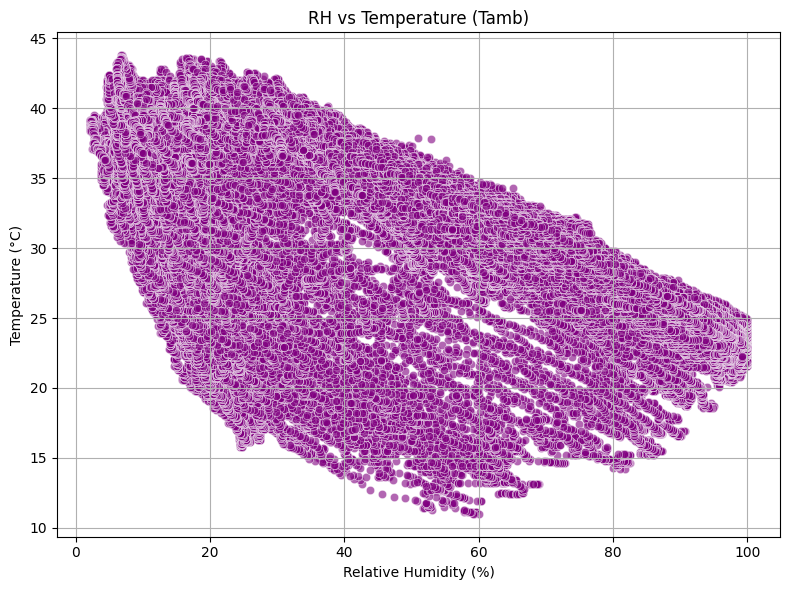

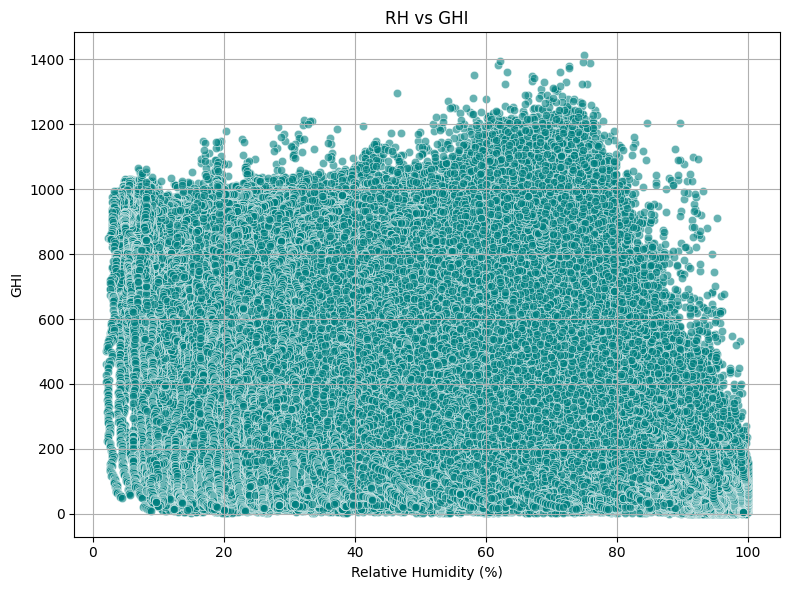

In [46]:
# --- 1) WS, WSgust, WD vs GHI ---
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.scatterplot(data=df_clean_with_timestap_index, x='WS', y='GHI', alpha=0.6)
plt.title("WS vs GHI")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("GHI")

plt.subplot(1,3,2)
sns.scatterplot(data=df_clean_with_timestap_index, x='WSgust', y='GHI', alpha=0.6, color='orange')
plt.title("WSgust vs GHI")
plt.xlabel("Wind Gust (m/s)")
plt.ylabel("GHI")

plt.subplot(1,3,3)
sns.scatterplot(data=df_clean_with_timestap_index, x='WD', y='GHI', alpha=0.6, color='green')
plt.title("WD vs GHI")
plt.xlabel("Wind Direction (°)")
plt.ylabel("GHI")

plt.tight_layout()
plt.show()

# --- 2) RH vs Tamb ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean_with_timestap_index, x='RH', y='Tamb', alpha=0.6, color='purple')
plt.title("RH vs Temperature (Tamb)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3) RH vs GHI ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean_with_timestap_index, x='RH', y='GHI', alpha=0.6, color='teal')
plt.title("RH vs GHI")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI")
plt.grid(True)
plt.tight_layout()
plt.show()

## Wind & Distribution Analysis
##### Wind rose or radial bar plot of WS/WD.

<Figure size 800x800 with 0 Axes>

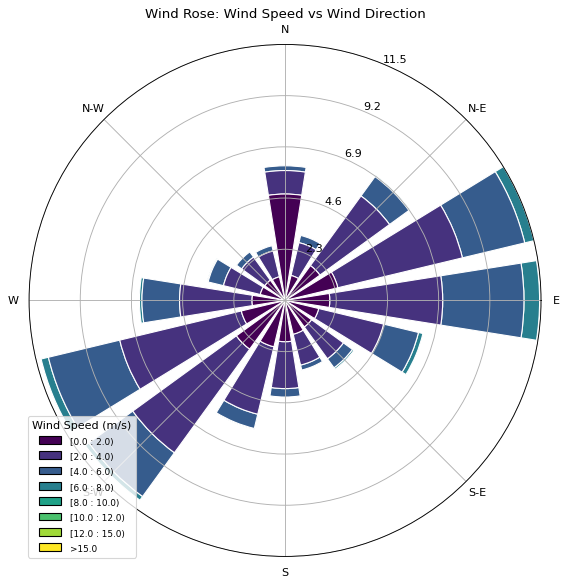

In [49]:
# Extract wind speed and direction
ws = df_clean_with_timestap_index['WS']
wd = df_clean_with_timestap_index['WD']

# Create a figure
plt.figure(figsize=(8,8))
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white', bins=[0, 2, 4, 6, 8, 10, 12, 15])
ax.set_legend(title="Wind Speed (m/s)")
plt.title("Wind Rose: Wind Speed vs Wind Direction")
plt.show();

#####  Histograms for GHI and one other variable (e.g., WS).


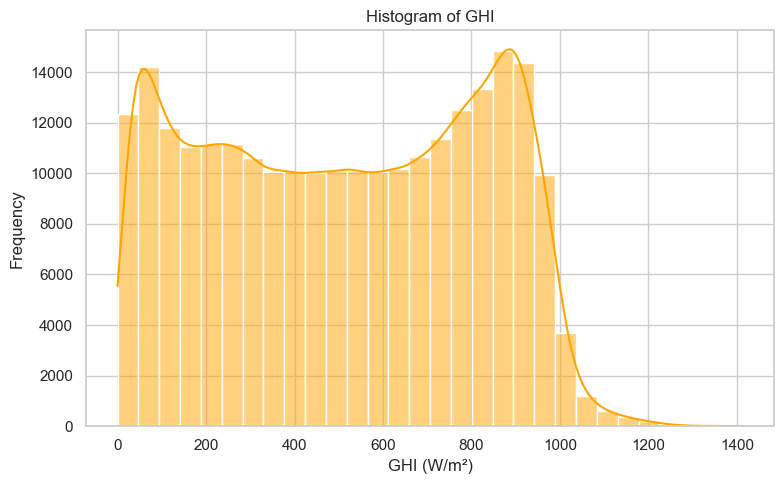

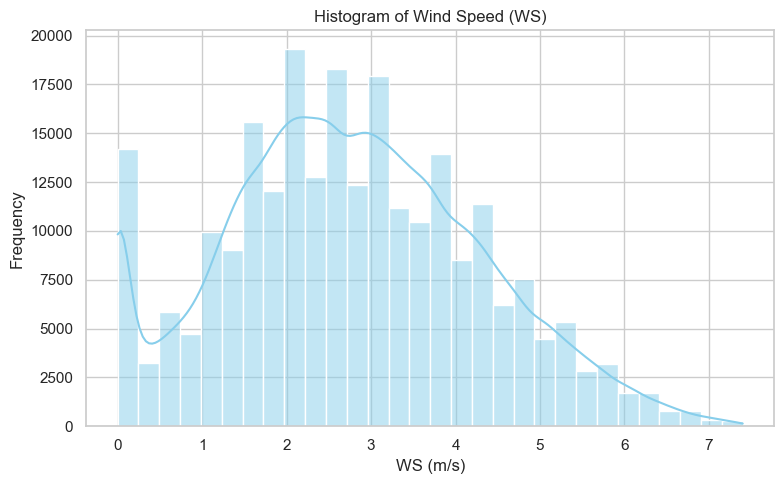

In [55]:

sns.set(style="whitegrid")

# --- Histogram for GHI ---
plt.figure(figsize=(8,5))
sns.histplot(df_clean_with_timestap_index['GHI'], bins=30, kde=True, color='orange')
plt.title("Histogram of GHI")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Histogram for WS ---
plt.figure(figsize=(8,5))
sns.histplot(df_clean_with_timestap_index['WS'], bins=30, kde=True, color='skyblue')
plt.title("Histogram of Wind Speed (WS)")
plt.xlabel("WS (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## Temperature Analysis
##### Examine how relative humidity (RH) might influence temperature readings and solar radiation.


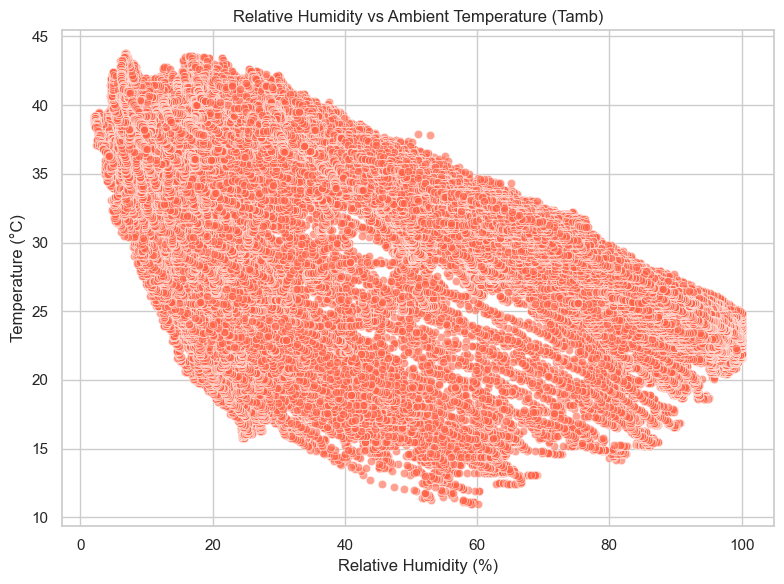

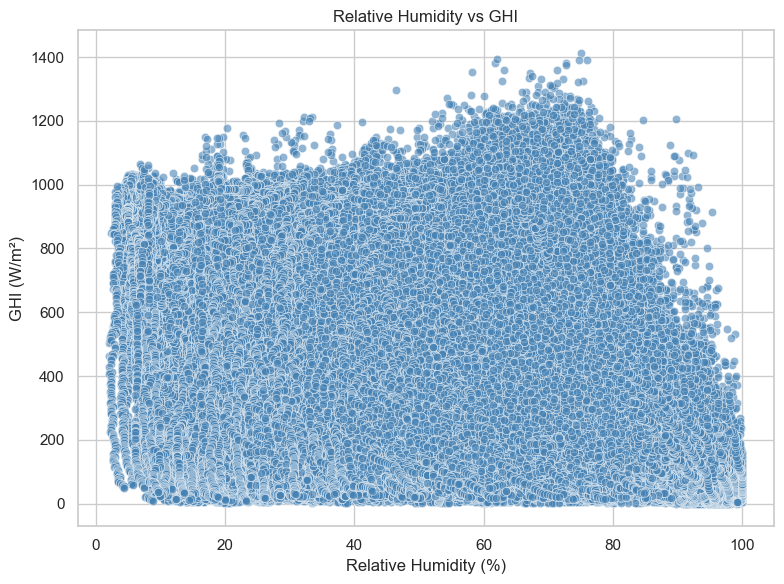

In [56]:
sns.set(style="whitegrid")

# RH vs Temperature (Tamb)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean_with_timestap_index, x='RH', y='Tamb', alpha=0.6, color='tomato')
plt.title("Relative Humidity vs Ambient Temperature (Tamb)")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# RH vs GHI (Global Horizontal Irradiance)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean_with_timestap_index, x='RH', y='GHI', alpha=0.6, color='steelblue')
plt.title("Relative Humidity vs GHI")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Correlation Coefficients

In [58]:
# Select variables
temp_vars = ['RH', 'Tamb', 'GHI', 'DNI', 'DHI']

# Compute correlation matrix
corr_matrix = df_clean_with_timestap_index[temp_vars].corr()
corr_matrix

RH      Tamb       GHI       DNI       DHI
RH    1.000000 -0.495616 -0.309222 -0.349352 -0.135874
Tamb -0.495616  1.000000  0.413599  0.288521  0.294176
GHI  -0.309222  0.413599  1.000000  0.767737  0.616700
DNI  -0.349352  0.288521  0.767737  1.000000  0.030067
DHI  -0.135874  0.294176  0.616700  0.030067  1.000000

### 1️⃣ Relative Humidity (RH) correlations

| Variable | Correlation with RH | Interpretation |
|----------|------------------|----------------|
| **Tamb** | -0.496 | Moderate negative correlation: higher RH → lower ambient temperature (humid days are cooler). |
| **GHI**  | -0.309 | Weak-to-moderate negative correlation: high humidity slightly reduces solar irradiance (clouds, haze, fog). |
| **DNI**  | -0.349 | Moderate negative correlation: direct solar radiation reduced by high humidity. |
| **DHI**  | -0.136 | Very weak negative correlation: diffuse radiation largely unaffected by RH. |

### 2️⃣ Temperature (Tamb) correlations

| Variable | Correlation with Tamb | Interpretation |
|----------|------------------|----------------|
| **GHI**  | 0.414 | Moderate positive correlation: warmer days coincide with higher solar irradiance. |
| **DNI**  | 0.289 | Weak-to-moderate positive correlation: direct sunlight slightly correlates with temperature. |
| **DHI**  | 0.294 | Weak positive correlation: ambient temperature slightly increases with diffuse irradiance. |


### 3️⃣ Solar radiation relationships

| Variables | Correlation | Interpretation |
|-----------|------------|----------------|
| **GHI vs DNI** | 0.768 | Strong positive correlation: global irradiance driven by direct sunlight. |
| **GHI vs DHI** | 0.617 | Moderate positive correlation: diffuse irradiance contributes significantly to global irradiance. |
| **DNI vs DHI** | 0.03 | Almost no correlation: direct and diffuse radiation largely independent. |


### 4️⃣ Summary of RH impact

- **RH has a cooling effect**: moderate negative correlation with temperature (-0.496).  
- **RH slightly reduces solar irradiance**, especially direct radiation (DNI).  
- High RH often coincides with **cloudy or humid conditions**, reducing solar panel output and temperature peaks.


## Bubble Chart


##### GHI vs. Tamb with bubble size = RH or BP.
#### Bubble Chart: GHI vs Tamb with RH as Bubble Size

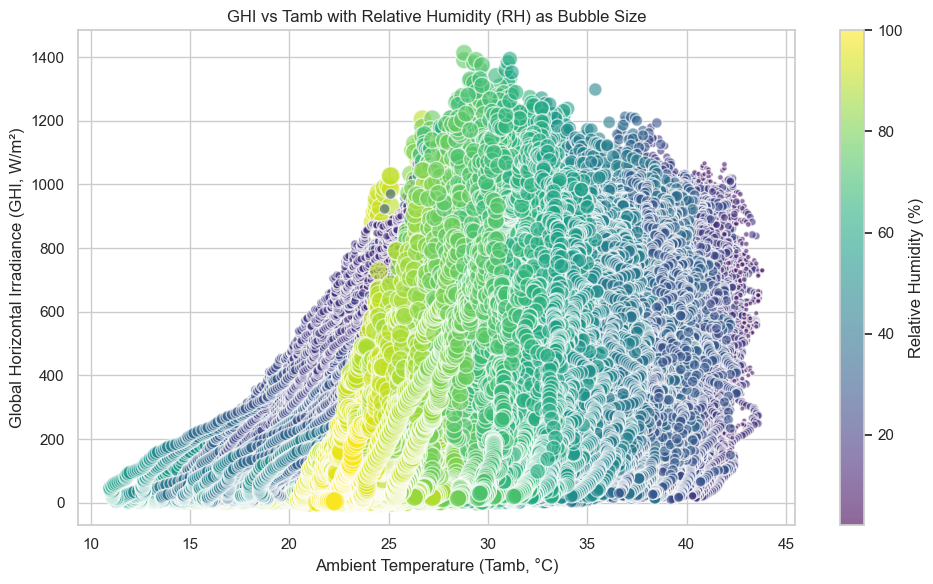

In [61]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))

# Bubble chart
plt.scatter(
    x=df_clean_with_timestap_index['Tamb'], 
    y=df_clean_with_timestap_index['GHI'],
    s=df_clean_with_timestap_index['RH']*2,  # Bubble size (scaled)
    alpha=0.6,
    c=df_clean_with_timestap_index['RH'],    # Bubble color by RH
    cmap='viridis',
    edgecolors='w'
)

plt.xlabel("Ambient Temperature (Tamb, °C)")
plt.ylabel("Global Horizontal Irradiance (GHI, W/m²)")
plt.title("GHI vs Tamb with Relative Humidity (RH) as Bubble Size")
cbar = plt.colorbar()
cbar.set_label("Relative Humidity (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Optional: Bubble Chart using BP (Barometric Pressure) instead of RH

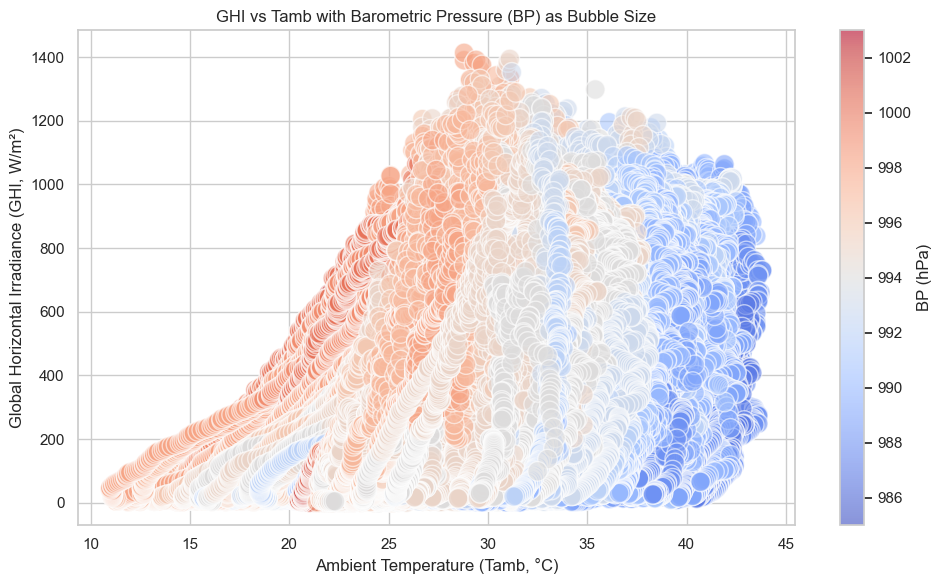

In [62]:
plt.figure(figsize=(10,6))

plt.scatter(
    x=df_clean_with_timestap_index['Tamb'], 
    y=df_clean_with_timestap_index['GHI'],
    s=df_clean_with_timestap_index['BP']/5,  # Bubble size (scaled)
    alpha=0.6,
    c=df_clean_with_timestap_index['BP'],    # Bubble color by BP
    cmap='coolwarm',
    edgecolors='w'
)

plt.xlabel("Ambient Temperature (Tamb, °C)")
plt.ylabel("Global Horizontal Irradiance (GHI, W/m²)")
plt.title("GHI vs Tamb with Barometric Pressure (BP) as Bubble Size")
cbar = plt.colorbar()
cbar.set_label("BP (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔹 Explanation

- **X-axis:** Ambient Temperature (`Tamb`)  
- **Y-axis:** Solar Radiation (`GHI`)  
- **Bubble size (`s`):** Relative Humidity (`RH`) or Barometric Pressure (`BP`)  
- **Bubble color (`c`):** Optional, adds another visual dimension  
- **`alpha=0.6`** → makes bubbles semi-transparent for better visibility  
- **`edgecolors='w'`** → white borders make bubbles easier to distinguish  

---

### 🔹 Insights You Can Get

- Observe how **GHI changes with temperature**.  
- Identify if **high RH or BP coincides with lower or higher GHI**.  
- Spot **clusters, anomalies, or trends** in the dataset.
